In [1]:
# Explore features 
# Load CES_prediction.Rproj
# Last updated: 5/8/2024 by NB 

In [2]:
# 0. Load objects 

rm(list=ls())
options(warn=-1)

# Libraries 
suppressPackageStartupMessages({

    rm(list=ls())
    library(dplyr)
    library(ggplot2)
    library(sjPlot)
    library(corrplot)
    library(stringr)
    library(tigris)
    library(sf)
    library(tidymodels)
    library(moments) # for skewness function
    library(caret) # for Yeo-Johnson transformations
    
})
    
# Set wd
setwd('~/Desktop/GitHub/CES_prediction')

# Data
load("temp/poll_clean.rda")

# Functions
source("scripts/0_functions/00_create_directory.R")

# Crosswalk 
state_xwalk <- read.csv("input/state_xwalk.csv")

pdf 
  2

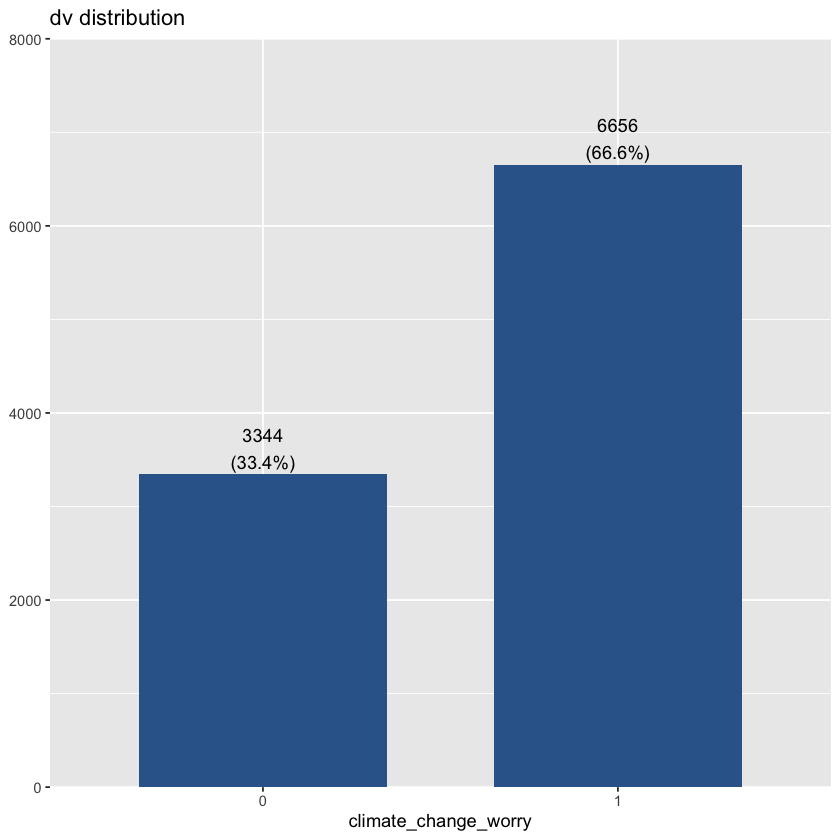

In [3]:
# 1. Explore dv 

# 1.1 Response distribution  
dv <- "climate_change_worry"
(bp <- poll_clean %>%
  plot_frq(!!sym(dv), title="dv distribution"))

directory_path <- "temp/EDA/dv/"
create_directory(directory_path)
save_plot(filename=paste0(directory_path, dv, ".jpg"), fig=bp, width=15, height=10)

  |======================================================================| 100%


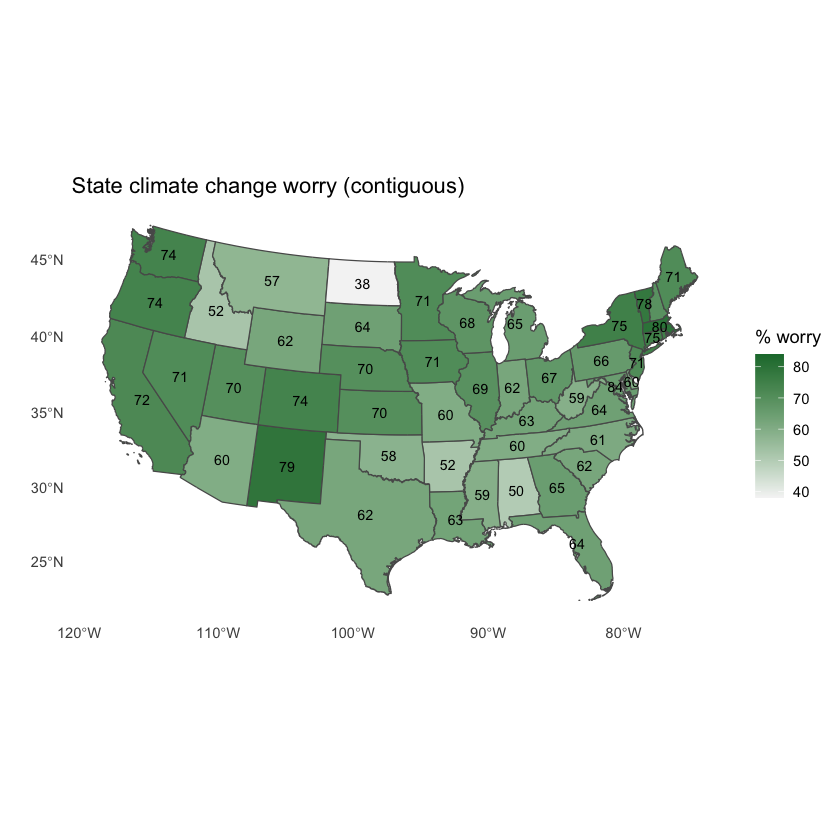

In [4]:
## 1.2 Response across states
# Merge in state abbreviation for clarity 
state_xwalk <- state_xwalk %>% 
  mutate(state_fips = str_pad(state_fips, width=2, pad="0"))

state_dv_pct <- poll_clean %>%
  left_join(state_xwalk, by="state_fips") %>% 
  dplyr::select(stusps, !!sym(dv)) %>% 
  mutate(!!sym(dv) := as.numeric(as.character(!!sym(dv)))) %>% 
  group_by(stusps, !!sym(dv)) %>%
  summarise(count = n(), .groups = 'drop') %>% 
  group_by(stusps) %>% 
  mutate(proportion = count / sum(count)) %>% 
  filter(!!sym(dv)==1) %>% 
  arrange(desc(proportion)) %>% 
  dplyr::select(stusps, proportion) %>% 
  mutate(percent = round(proportion, 2) *100) %>% 
  data.frame()

# Plot bar plot of state heat worry in descending order
bp_state <- ggplot(state_dv_pct, aes(y = reorder(stusps, percent), x = percent)) +
  geom_bar(stat = "identity", fill="#1C7839") +
  labs(title = paste0("State climate change concern descending"), 
       y = "State", 
       x = "% worry") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

ggsave("temp/EDA/dv/state_worry_barplot.png", plot= bp_state, width=6, height=10)   

## Map of state heat worry 
state_shp <- states(year=2022, cb=TRUE) 
state_dv_geo_all <- left_join(state_shp, state_dv_pct, by = c("STUSPS" = "stusps")) %>% 
  filter(STUSPS %in% state_dv_pct$stusps) %>% 
  st_transform(crs = 5070) %>% 
  mutate(centroid = st_centroid(geometry))

state_dv_geo_contig <- state_dv_geo_all %>% 
  filter(!STUSPS %in% c("AK", "HI"))


state_worry_all <- ggplot(state_dv_geo_all) +
    geom_sf(aes(fill = percent), lwd=0.35) +
    geom_sf_text(aes(label = percent, geometry = centroid), check_overlap = TRUE, size = 3) + 
    scale_fill_gradient(low = "whitesmoke", high ="#1C7839", name = "% worry") +  # You can choose a different palette if you prefer
    labs(title = "State climate change worry",
         fill = "Worry", 
         x="", y="") +
    theme_minimal()

(state_worry_contig <- ggplot(state_dv_geo_contig) +
    geom_sf(aes(fill = percent), lwd=0.35) +
    geom_sf_text(aes(label = percent, geometry = centroid), check_overlap = TRUE, size = 3) + 
    scale_fill_gradient(low = "whitesmoke", high ="#1C7839", name = "% worry") +  # You can choose a different palette if you prefer
    labs(title = "State climate change worry (contiguous)",
         fill = "Worry", 
         x="", y="") +
    theme_minimal()) + 
    theme(panel.grid.major = element_blank(),  
          panel.grid.minor = element_blank())


# Save 
ggsave("temp/EDA/dv/state_worry_map.png", plot=state_worry_all, width=10, height=6)
ggsave("temp/EDA/dv/state_worry_map_contiguous.png", plot=state_worry_contig, width=10, height=6)

In [5]:
# 2. Explore categorical features across the dv


# function to find the proportions of dv (0/1) across cat features
calc_response_proportion <- function(df, feat, dv) {
  df_prop <- df %>%
    group_by(!!sym(feat), !!sym(dv)) %>%
    summarise(count = n(), .groups = 'drop') %>% 
    group_by(!!sym(feat)) %>% 
    mutate(proportion = count / sum(count))
  return(df_prop)
}

# function to produce facet plots visualizing the df created by calc_response_proportion
create_facet_barplots <- function(df, feat, dv, proportion_col, nrow) {
  fp <- ggplot(df, aes(x = !!sym(dv), y = !!sym(proportion_col)*100, fill=!!sym(dv))) +
    geom_bar(stat="identity", position = position_dodge()) +
    geom_text(aes(label = scales::percent(!!sym(proportion_col), accuracy = 1), y = !!sym(proportion_col)*100), 
              position = position_dodge(width = 0.9), 
              vjust = -1) +
    ylim(0, 100) +
    facet_wrap(as.formula(paste0("~", feat)), nrow = nrow, scales = "free_x") +
    scale_fill_manual(values = c("0" = "#3ed5c4", "1" = "#D53E4F")) +
    labs(title = paste0(dv, " worry by ", feat),
         x = dv,
         y = "percent in response group") 
  return(fp)
}

# Identify cat features and the number levels 
cat_features <- names(poll_clean)[sapply(poll_clean, is.factor)]
cat_features <- setdiff(cat_features, c("climate_change_worry", "state_fips"))
(levels <- sapply(poll_clean[, cat_features], nlevels))

# Plot 
nrows <- round(unname(levels)/2)
directory_path <- "temp/EDA/features/dv_analysis/"
create_directory(directory_path)

lapply(seq_along(cat_features), function(idx) {
  fp <- poll_clean %>% 
    calc_response_proportion(feat=cat_features[idx], dv=dv) %>% 
    create_facet_barplots(feat=cat_features[idx], dv=dv, 
                          proportion_col="proportion", nrow=nrows[idx])
  file_path <- paste0(directory_path, cat_features[idx], ".png")
  ggsave(file_path, plot = fp, width = 10, height = 6)
  
})

gender   college_degree   white_non_hisp         hispanic 
               4                2                2                3 
         votereg     pol_identity     news_engaged          citizen 
               2                4                2                3 
  urban_resident   rural_resident         investor      evangelical 
               2                2                3                3 
         married     union_member       home_owner    income_bucket 
               2                2                2                5 
military_service           parent     heterosexual 
               2                3                2

[[1]]
[1] "temp/EDA/features/dv_analysis/gender.png"

[[2]]
[1] "temp/EDA/features/dv_analysis/college_degree.png"

[[3]]
[1] "temp/EDA/features/dv_analysis/white_non_hisp.png"

[[4]]
[1] "temp/EDA/features/dv_analysis/hispanic.png"

[[5]]
[1] "temp/EDA/features/dv_analysis/votereg.png"

[[6]]
[1] "temp/EDA/features/dv_analysis/pol_identity.png"

[[7]]
[1] "temp/EDA/features/dv_analysis/news_engaged.png"

[[8]]
[1] "temp/EDA/features/dv_analysis/citizen.png"

[[9]]
[1] "temp/EDA/features/dv_analysis/urban_resident.png"

[[10]]
[1] "temp/EDA/features/dv_analysis/rural_resident.png"

[[11]]
[1] "temp/EDA/features/dv_analysis/investor.png"

[[12]]
[1] "temp/EDA/features/dv_analysis/evangelical.png"

[[13]]
[1] "temp/EDA/features/dv_analysis/married.png"

[[14]]
[1] "temp/EDA/features/dv_analysis/union_member.png"

[[15]]
[1] "temp/EDA/features/dv_analysis/home_owner.png"

[[16]]
[1] "temp/EDA/features/dv_analysis/income_bucket.png"

[[17]]
[1] "temp/EDA/features/dv_analysis/military_service.png"

[[18]]
[1] "temp/EDA/features/dv_analysis/parent.png"

[[19]]
[1] "temp/EDA/features/dv_analysis/heterosexual.png"

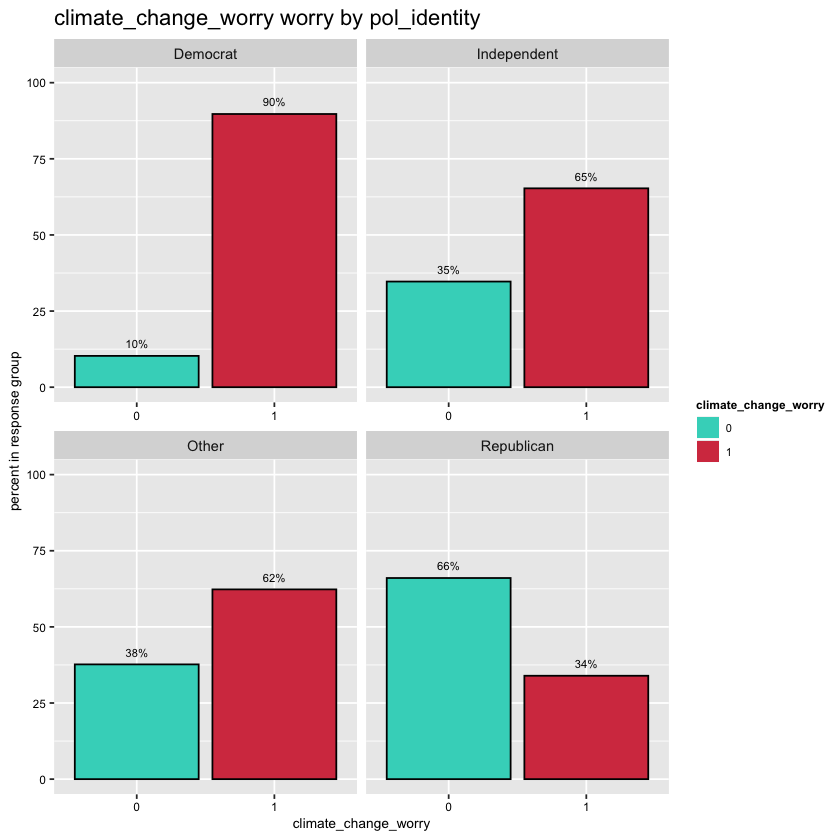

In [6]:
# Example plot 
(fp <- poll_clean %>% 
   calc_response_proportion(feat='pol_identity', dv='climate_change_worry') %>% 
   create_facet_barplots(feat='pol_identity', dv='climate_change_worry', 
                         proportion_col="proportion", nrow=2))

In [7]:
# 3. Explore numeric features across the dv

# Scale numeric features to better visualize distributions -- also recode dv for clarity
poll_clean_scl <- poll_clean %>% 
  mutate_if(is.numeric, scale) %>% 
  mutate(!!sym(dv) := ifelse(!!sym(dv) == "1", "worried", "not worried"))

# Write function to produce facet density plots similar to prev function 
create_facet_plots_dens <- function(df, feat, dv, binwidth) {
  dv_label <- sub("dv_", "", dv)
  fp <- ggplot(df, aes(x = !!sym(feat), fill=!!sym(dv), col=!!sym(dv))) +
    geom_density(alpha=0.5) +
    scale_fill_manual(values = c("#3ed5c4", "#D53E4F")) +
    scale_color_manual(values = c("#3ed5c4", "#D53E4F")) +
    labs(title = paste0(dv_label, " across ", feat),
         x = feat,
         y = "Frequency")
  return(fp)
}


# Identify num features 
num_features <- names(poll_clean)[sapply(poll_clean, is.numeric)]

# Plot with same directory_path as cat features
lapply(num_features, function(feat) {
  fp <- poll_clean_scl %>% 
    create_facet_plots_dens(feat=feat, dv=dv, binwidth=0.05)
  file_path <- paste0(directory_path, feat, ".png")
  ggsave(file_path, plot = fp, width = 10, height = 6)
})

[[1]]
[1] "temp/EDA/features/dv_analysis/age.png"

[[2]]
[1] "temp/EDA/features/dv_analysis/noaa_cost_pc.png"

[[3]]
[1] "temp/EDA/features/dv_analysis/cdc_svi_socioecon.png"

[[4]]
[1] "temp/EDA/features/dv_analysis/cdc_svi_demo.png"

[[5]]
[1] "temp/EDA/features/dv_analysis/cdc_svi_race.png"

[[6]]
[1] "temp/EDA/features/dv_analysis/cdc_svi_housing.png"

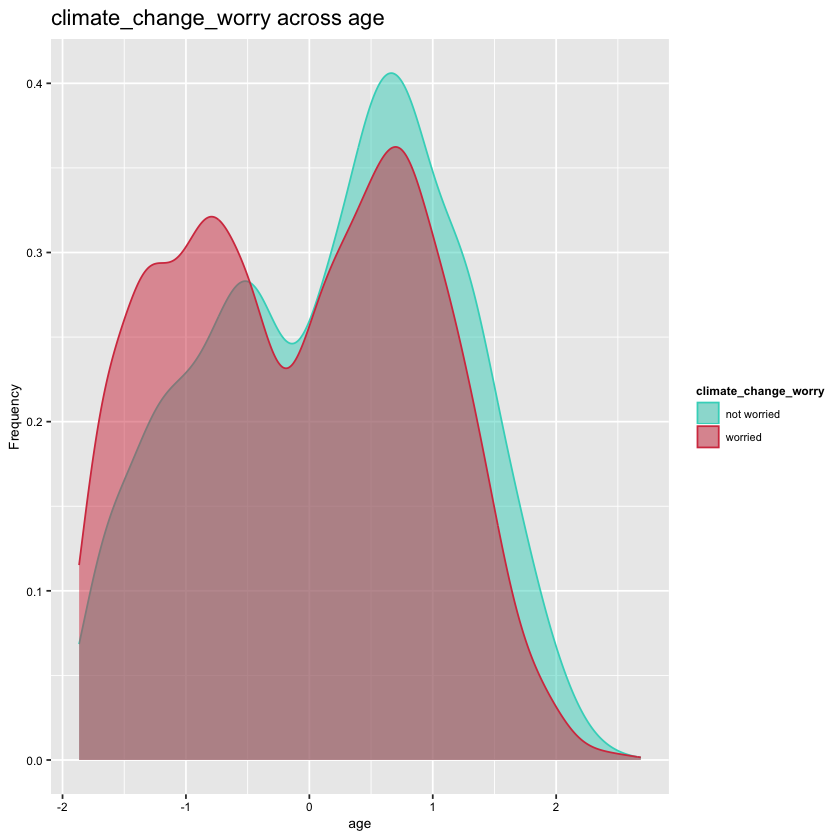

In [8]:
# Example plot 
(fp <- poll_clean_scl %>% 
   create_facet_plots_dens(feat='age', dv='climate_change_worry', binwidth=0.05))

[1] "cdc_svi_socioecon" "cdc_svi_demo"      "cdc_svi_race"

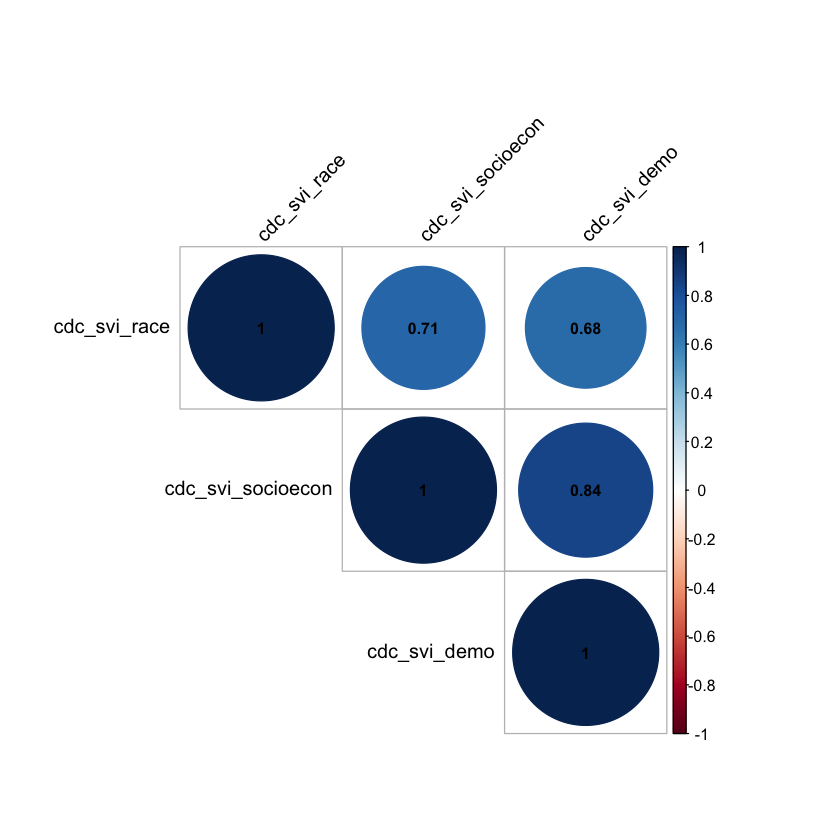

In [9]:
# 4. Explore numeric features - correlations, low variance

# Identify highly-correlated numeric features
corr_matrix <- cor(poll_clean[sapply(poll_clean, is.numeric)])
threshold <- 0.70
(corr_features <- colnames(corr_matrix)[apply(corr_matrix, 1, function(x) sum(abs(x) > threshold) > 1)])

# plot 
cor_matrix_cf <- cor(poll_clean[, corr_features])
corrplot(
  cor_matrix_cf,
  method = "circle", type = "upper", order = "hclust",
  tl.col = "black", 
  tl.srt = 45, tl.cex = 1, number.cex = 0.8,  
  addCoef.col = "black", bg = "white", pch.col = "black",
  pch.cex = 2,
  mar = c(0, 0, 1, 0)
)

In [10]:
# identify low-variance features 
model_formula <- as.formula(paste0(dv, " ~ ."))
lowvar_recipe <- poll_clean %>%
  recipe(model_formula) %>% 
  step_nzv(all_predictors(), freq_cut = 95/5) 

poll_lowvar_proc <- lowvar_recipe %>% prep() %>% juice()
(lowvar_features <- setdiff(names(poll_clean), names(poll_lowvar_proc)))

[1] "citizen"

In [ ]:
# 5. Explore numeric features - distributions & transformations

## 5.1 Find skewness of features ---------------------------------------------
# This will inform which transformations (if any) we should apply to each feature 
poll_clean_num <- poll_clean[sapply(poll_clean, is.numeric)]

# Find skewness of all features 
calc_skewness <- function(df) {
  skew_vec <- skewness(df)
  names <- names(skew_vec)
  values <- unname(skew_vec)
  df_skew <- data.frame(feature = names,
                        value = values)
  return(df_skew)
}

feature_skewness <- calc_skewness(poll_clean_num)

# Separate into left and right skewed features
find_right_skewed <- function(skewness_df, skew_col, threshold) {
  skewed_features <- skewness_df %>%
    dplyr::filter(!!sym(skew_col) > threshold) %>%
    pull(feature)
  
  return(skewed_features)
}


find_left_skewed <- function(skewness_df, skew_col, threshold) {
  skewed_features <- skewness_df %>%
    dplyr::filter(!!sym(skew_col) < threshold) %>%
    pull(feature)
  
  return(skewed_features)
}

right_skewed <- find_right_skewed(feature_skewness, "value", threshold=0.5)
poll_right_skewed <- poll_clean_num %>% 
    dplyr::select(all_of(right_skewed))

# There are no left skewed features so we will only have to treat right-skewed
left_skewed <- find_left_skewed(feature_skewness, "value", threshold=-0.5)

## 5.2 Define transformations to apply  ----------------------------------------
# Check the range for all the features we will be using -- the minimum value = 0 
sapply(poll_right_skewed, range)

# Define transformations to apply to right and left skewed features
transformations_right <- list(
  log = function(x) log(x + 0.1), # to handle 0s
  sqrt = function(x) sqrt(x + 0.1) # to handle 0s 
)

# In case we did have left skewed features 
transformations_left <- list(
  square = function(x) x**2
#   exp = function(x) exp(x)  # exponential transformation caused problems
  
)

# Write function to apply transformations specified above
transform_features <- function(df, transformations) {
  for(feature in names(df)){
    for(tf in names(transformations)) {
      tf_col_name <- paste(feature, tf, sep = "_")
      df[[tf_col_name]] <- transformations[[tf]](df[[feature]])
    }
    new_name <- paste0(feature, "_none") # rename original cols to indicate no applied transformation 
    names(df)[names(df) == feature] <- new_name
  }
  return(df)
  
}

# Write function to apply the Yeo-Johnson transformation -- can be applied to both right and left skewed
# Because the fxn input is a df, we write a separate function
YeoJohnson_transform <- function(df) {
  preprocessed_pred <- preProcess(df, method = "YeoJohnson")
  transformed_df <- predict(preprocessed_pred, df)
  names(transformed_df) <- paste0(names(transformed_df), "_yeojohnson")
  return(transformed_df)
}


## 5.3 Apply transformations ---------------------------------------------------
apply_right_transform <- function(df) {
  df1 <- transform_features(df, transformations_right)
  df2 <- YeoJohnson_transform(df)
  df3 <- cbind(df1, df2)
  return(df3)
}

poll_right_transformed <- apply_right_transform(poll_right_skewed)


## 5.4 Scale data to plot distributions of all transformations  ----------------
scale_df <- function(df) {
  df_scl <- sapply(df, scale) %>% 
    data.frame()
  return(df_scl)
}

poll_right_transformed <- poll_right_transformed %>% 
  scale_df()


## 5.5 Make violin plots  ------------------------------------------------------
# Write a function to apply to both left and right skewed -- loops through all features
plot_violin <- function(df, directory_path) {
  long_df <- pivot_longer(df,
                          cols = everything(),
                          names_to = c("feature", "transformation"),
                          names_pattern = "(.*)_(.*)")
  for (feat in unique(long_df$feature)) {
    df_feature <- filter(long_df, feature == feat)
    vp <- ggplot(df_feature, aes(x = transformation, y = value, fill = transformation)) +
      geom_violin() +
      geom_boxplot(width = 0.1, fill = "white") +
      labs(title = feat,
           x = "Transformation",
           y = "Value")
    
    file_path <- paste0(directory_path, feat, ".png")
    ggsave(file_path, plot = vp, width = 10, height = 6)
    
  }
}


# Make plots of transformations for right skewed features
directory_path <- paste0("temp/EDA/features/transformations/")
create_directory(directory_path)

plot_violin(poll_right_transformed, directory_path)

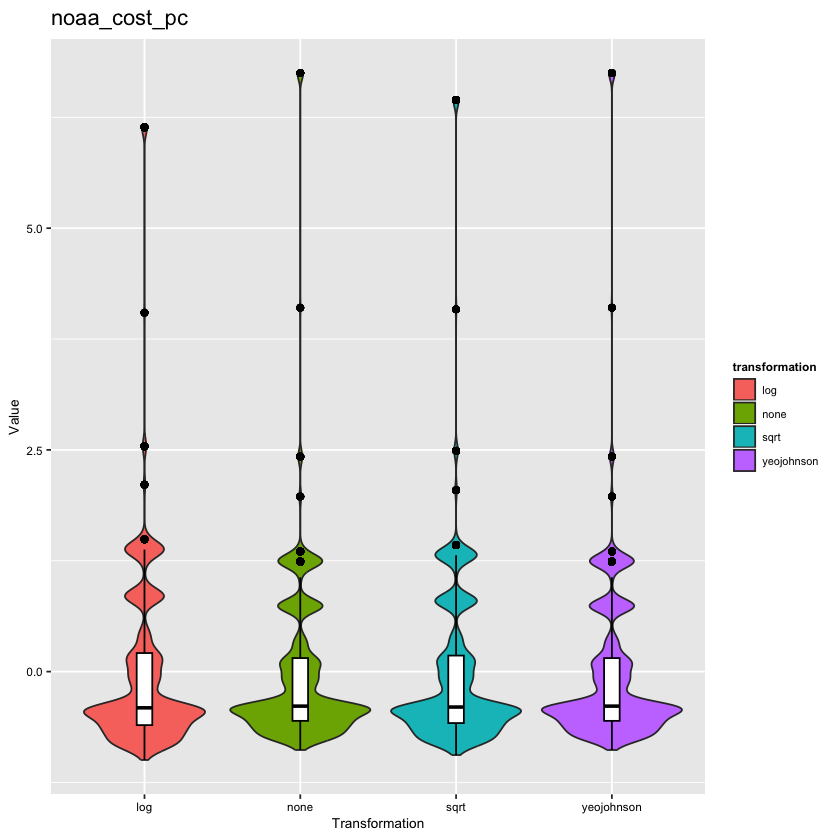

In [12]:
# Example plot -- this feature does not respond much to the transformations applied
long_df <- pivot_longer(poll_right_transformed, cols = everything(), names_to = c("feature", "transformation"), 
                      names_pattern = "(.*)_(.*)")
df_feature <- filter(long_df, feature == 'noaa_cost_pc')
(vp <- ggplot(df_feature, aes(x = transformation, y = value, fill = transformation)) +
  geom_violin() +
  geom_boxplot(width = 0.1, fill = "white") +
  labs(title = 'noaa_cost_pc',
       x = "Transformation",
       y = "Value"))

state_fips,noaa_cost_pc
<fct>,"<dbl[,1]>"
22,6.748325
38,4.102926


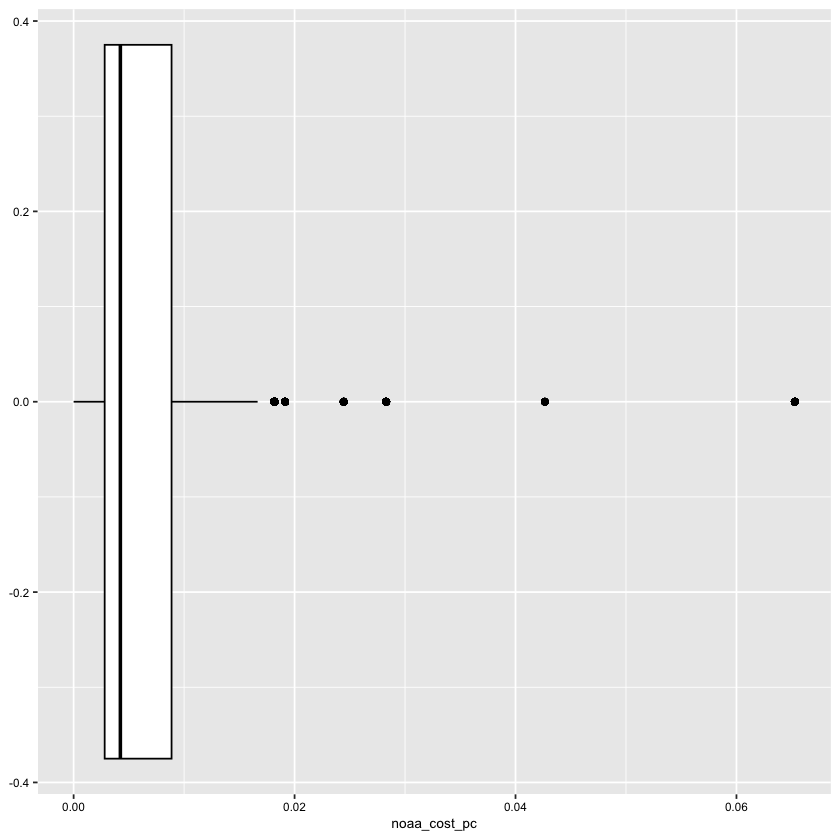

In [13]:
# 6. Outlier analysis 

ggplot(poll_clean, aes(noaa_cost_pc)) +
  geom_boxplot() 

# Find outliers 
z_scores <- scale(poll_clean_num$noaa_cost_pc)
is_outlier <- poll_clean_scl$noaa_cost_pc > 3 | poll_clean_scl$noaa_cost_pc < -3
poll_clean_scl$is_outlier <- c(is_outlier)

# Find outlier states and their associated noaa disaster pc cost 
(poll_clean_scl %>% 
  filter(is_outlier == TRUE) %>% 
  dplyr::select(state_fips, noaa_cost_pc) %>% 
  distinct())

# Outlier states ND and LA -- ND hit by drought and LA hit by flooding/hurricanes so makes sense

In [14]:
# 7. Conclusions 

# 1. hispanic, investor, news_engaged, parent, and votereg are not very separable across the dv 
# 2. CDC features are highly correlated -- use PCA to combine into one feature
# 3. Citizen is a low variance feature but appears predictive so do not remove
# 4. Log transform noaa_cost_pc to normalize 

eda_results <- list()
eda_results$weaker_features <-  c("hispanic", "votereg", "news_engaged", "investor", "parent")
eda_results$pca_transform <- corr_features
eda_results$log_transform <- right_skewed

save(eda_results, file = "temp/eda_results.rda")
